## Introduction
Computed herein are the Elastic Spectra for horizontal and vertical seismic loading in accordance with draft TS 1170.5 [2024]. This is a unverified and uncontrolled document.

Please verify before any serious use. I'll not take any responsibility for correctness.

This is also an example of basic python programming.

## Import python packages

In [13]:
# Import built-in packages
from pathlib import Path
import re
from typing import Union
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

# Import 3rd party packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aquarel import load_theme
import folium
from folium.plugins import MousePosition
import geopandas as gpd
from geopy.geocoders import Nominatim
%matplotlib inline

## Define data folder path and read all data files

In [14]:
hazard_data_folder = Path.cwd() / "TS1170_hazard_data_v1"

# Read the list of locations available
urban_area_file = hazard_data_folder/"urban_locations.csv"
grid_location_file = hazard_data_folder/"grid_locations.csv"

urban_areas = pd.read_csv(urban_area_file)
grid_locations = pd.read_csv(grid_location_file)


# Following data files are required. 
# ----------------------------------
# major_faults.geojson. Contains info related to major faults requiring near-fault factor
# urban_area_polygons.geojson. Contains info related to extent of all urban locations
# grid_locations.geojson. Contains coordinates of 3740 grids at a resolution of 0.1 x 0.1 degree

# urban_locations.csv. Contains a list of urban locations.
# grid_locations.csv. Contains a list of grid locations.

# TS1170_grids_apoe_25.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/25.
# TS1170_grids_apoe_50.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/50.
# TS1170_grids_apoe_100.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/100.
# TS1170_grids_apoe_250.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/250.
# TS1170_grids_apoe_500.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/500.
# TS1170_grids_apoe_1000.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/1000.
# TS1170_grids_apoe_2500.csv.  Contains PGA, Sas, TC at all grid locations for 5 site classes and annual exccedance of probability of 1/2500.

# TS1170_urban_apoe_25.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/25.
# TS1170_urban_apoe_50.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/50.
# TS1170_urban_apoe_100.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/100.
# TS1170_urban_apoe_250.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/250.
# TS1170_urban_apoe_500.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/500.
# TS1170_urban_apoe_1000.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/1000.
# TS1170_urban_apoe_2500.csv.  Contains PGA, Sas, TC at all urban areas for 5 site classes and annual exccedance of probability of 1/2500.

## Define all functions

### Define function to get coordinate from a given address

In [15]:
def address_to_coordinate(site_location: str = "1 Grey Street, Wellington") :
    """
    Converts an address string to latitude and longitude coordinates.

      Args:
          site_location (str): The input string to process.

      Returns:
          tuple: A tuple containing the latitude and longitude values,
              or None if the address is not found.

    """

    # Regular expressions for different imput patterns
    address_regex = r"\d+ [A-Za-z]+ [A-Za-z]+, [A-Za-z]"
    coordinate_regex = r"^[-+]?\d+\.\d+,[-+]?\d+\.\d+$"
    city_regex = r"[A-Za-z]+(?: [A-Za-z]+)*"

    # Check for address format and geocode
    if re.match(address_regex, site_location) :

        geolocator = Nominatim(user_agent = 'NZ seismic hazard map')
        location = geolocator.geocode(site_location)

        if location :
            return (location.latitude, location.longitude)
        else :
            raise ValueError("Address not found.")

    # Check for coordinate fomrat
    elif re.match(coordinate_regex, site_location) :
        try :
            latitude, longitude = map(float, site_location.split(","))
            return (latitude, longitude)
            
        except ValueError :
            raise ValueError("Invalid coordinate format.")                       

    # Check for city name format
    elif re.match(city_regex, site_location):
        return site_location
    else:
        raise ValueError("Invalid input format.")

# Example usage of an address, 1 space after every number or word
#site_location = "1 Grey Street, Wellington"
#result = get_coordinate(site_location)
#print(result)

#site_location = "Wellington"
#result = get_coordinate(site_location)
#print(result)

# Example usage of a coordinate, comma separated with no space.
#site_location = "-41.2849784,174.7762051"
#result = get_coordinate(site_location)
#print(result)

In [16]:
### Check whether a site is in NZ or outside of NZ

In [17]:
def get_site_coordinate(site_location: str = "1 Grey Street, Wellington"):

    site_coordinate = address_to_coordinate(site_location)
    
    # Urban area is given
    if isinstance(site_coordinate, str):
        
        site_location_index = urban_areas [urban_areas ['location'] == site_coordinate]

        if site_location_index.empty :
            raise TypeError("Site is outside of Table 3.4 named locations. Provide a location in NZ")

        return ("urban_area", site_location_index.index[0])

    else :

        nearest_grid = (round(float(site_coordinate[0]), 1), round(float(site_coordinate[1]), 1))
        nearest_grid_str = f"{nearest_grid[0]:.3f}~{nearest_grid[1]:.3f}"
        
        site_location_index = grid_locations [grid_locations ['coordinate'] == nearest_grid_str]

        if site_location_index.empty :
            raise ValueError(f"site_coordinate is outside of NZ.")           

        return ("grid_location", site_location_index.index[0])

### Compute acceleration and displacement spectra for a site class and a given return period

In [18]:
def define_TS1170_spectra(pga: float = 1.79,
                          Sas: float = 3.85,
                          fault_D: Union[float, str] = 0.0,
                          Tc: float = 0.40,
                          Tb: float = 0.10,
                          Td: float = 3.0,
                          Tn: np.ndarray = np.linspace(0.0, 5.0, 100)) -> np.ndarray:

    """
    Computes spectral acceleration spectra for horizontal loading using draft TS1170.5.

    Args:
        pga (float, optional): Peak ground acceleration. Defaults to 1.79.
        Sas (float, optional): Short period spectral acceleration. Defaults to 3.85.
        fault_D (float or str, optional): Fault distance. Defaults to 0.0.
        Tc (float, optional): Start of velocity plateau. Defaults to 0.40.
        Tb (float, optional): Start of acceleration plateau. Defaults to 0.10.
        Td (float, optional): Start of displacement plateau. Defaults to 3.0.
        Tmax (float, optional): Maximum period. Defaults to 5.

    Returns:
        numpy.ndarray: A 2D array with columns [Tn, psa].
        
    """    

    # Compute spectral acceleration
    Sa = pga + (Sas - pga) * (Tn/Tb)
    Sa[Tn > Tb] = Sas
    Sa[Tn > Tc] = Sas * Tc / Tn[Tn > Tc]
    Sa[Tn > Td] = Sas * (Tc / Tn[Tn > Td]) * (Td / Tn[Tn > Td]) ** 0.5

    # Compute max near-fault factor as a function of period
    Nmax = np.maximum(1.0, 0.24 * Tn + 0.64)
    Nmax[Tn > 4.0] = np.minimum(1.72, 0.12 * Tn[Tn > 4.0] + 1.12)

    # Compute near-fault factor
    if isinstance(fault_D, str) and (fault_D == ">20"):
        N = np.ones_like(Tn)

    elif isinstance(fault_D, (int, float)) and np.isnan(fault_D):
        N = np.ones_like(Tn)

    else:
        fault_D = float(fault_D)
        N = np.where(fault_D <= 2.0, Nmax, 1 + (Nmax - 1) * (20 - fault_D) / 18.0)

    # Compute spectral acceleration and displacement
    psa = Sa * N
    sd = (0.50*Tn/np.pi) **2 * psa * 9.807

    spectra = np.array([Tn, psa, sd]).T
    
    return spectra


# Example usage
#spectra = define_TS1170_spectra()
#print(spectra)


### Plot acceleration and displacement spectra for all site classes under a given return period

In [19]:
def plot_spectra(spectra) :
    """Plots spectral acceleration and displacement as a function of period.

    Args:
        spectra (numpy.ndarray): A 2D array with columns [Tn, psa, sd].
    """
    
        
    #theme = load_theme("arctic_light")
    #theme.apply()
        
    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Add spectral acceleration plot
    for i, site in enumerate(spectra['site_classes']) : 
        axs[0].plot(spectra['Tn'][:], spectra['psa'][:, i], label=f"Class {site}", linewidth=2)
        
    axs[0].set_xlabel('Period (s)')
    axs[0].set_ylabel('Spectral Acceleration (g)')
    axs[0].legend()
    axs[0].grid(True, which='major', linestyle='-', linewidth=0.75)
    axs[0].grid(True, which='minor', linestyle='--', linewidth=0.5)
    axs[0].minorticks_on()


    # Add spectral displacement plot
    for i, site in enumerate(spectra['site_classes']) : 
        axs[1].plot(spectra['Tn'][:], spectra['sd'][:, i], label=f"Class {site}", linewidth=2)
    
    axs[1].set_xlabel('Period (s)')
    axs[1].set_ylabel('Spectral Displacement (m)')
    axs[1].legend()
    axs[1].grid(True, which='major', linestyle='-', linewidth=0.75)
    axs[1].grid(True, which='minor', linestyle='--', linewidth=0.5)
    axs[1].minorticks_on()
        
    # Show the plot
    plt.show()  
    #theme.apply_transforms()

# Define the interactive function
#def interactive_plot(func, **kwargs):
#    interact_obj = interactive(func, **kwargs)
#    return interact_obj

# Example usage
#plot_spectra(spectra)

### Get hazard data from Tables 3.4 & 3.5 for a given location (urban & rural settlement)

In [20]:
spectra = {}

def process_data(site_info, return_period, Tmax = 5.0) :

    # Read the list of return periods and site classes available
    return_periods = [25, 50, 100, 250, 500, 1000, 2500]
    site_classes = ['I', 'II', 'III', 'IV', 'V', 'VI']
    
    # Compute time period as a numpy array
    Tn = np.linspace(0.0, Tmax, 100)

    # Initialize 
    acceleration_spectra = np.zeros((len(Tn), len(site_classes)))
    displacement_spectra = np.zeros((len(Tn), len(site_classes)))

    if site_info[0] == 'urban_area':        

        # Read hazard data
        hazard_file = hazard_data_folder / f"TS1170_urban_apoe_{return_period}.csv"
        hazard_data = pd.read_csv(hazard_file)
        index = site_info[1]               

        # Access hazard values for various site classes
        eqM, fault_D = hazard_data.loc[index, ['M', 'D']]        

        for count, site_class in enumerate(site_classes) :

            pga, Sas = hazard_data.loc[index, [f'{site_class}-PGA', f'{site_class}-Sas']]
            Tc = hazard_data.loc[index, f'{site_class}-Tc']

            # Compute spectral acceleration and displacement for one site class
            spectra_TS1170 = define_TS1170_spectra(fault_D = fault_D,
                                                   pga = pga,
                                                   Sas = Sas,
                                                   Tc = Tc,
                                                   Tn = Tn,
                                                   )
            acceleration_spectra[:, count] = spectra_TS1170[:, 1]
            displacement_spectra[:, count] = spectra_TS1170[:, 2]

    else :        

        # Read hazard data
        hazard_file = hazard_data_folder / f"TS1170_grids_apoe_{return_period}.csv"
        hazard_data = pd.read_csv(hazard_file)
        index = site_info[1]               

        # Access hazard values for various site classes
        eqM, fault_D = hazard_data.loc[index, ['M', 'D']]        

        for count, site_class in enumerate(site_classes) :

            pga, Sas = hazard_data.loc[index, [f'{site_class}-PGA', f'{site_class}-Sas']]
            Tc = hazard_data.loc[index, f'{site_class}-Tc']

            # Compute spectral acceleration and displacement for one site class
            spectra_TS1170 = define_TS1170_spectra(fault_D = fault_D,
                                                   pga = pga,
                                                   Sas = Sas,
                                                   Tc = Tc,
                                                   Tn = Tn,
                                                   )
            acceleration_spectra[:, count] = spectra_TS1170[:, 1]
            displacement_spectra[:, count] = spectra_TS1170[:, 2]


    default_acceleration = np.max(acceleration_spectra[:, 1:-1], axis=1)
    default_displacement = np.max(displacement_spectra[:, 1:-1], axis=1)
    site_classes.append('default')

    spectra['psa'] = np.column_stack([acceleration_spectra, default_acceleration])
    spectra['sd'] = np.column_stack([displacement_spectra, default_displacement])
    spectra['Tn'] = Tn
    spectra['eqM'] = eqM
    spectra['fault_D'] = fault_D
    spectra['site_classes'] = site_classes

    return spectra

# Example usage
#print(site_info)
#spectra = process_data(site_info, return_period = 500)
#plot_spectra(spectra)

In [21]:
# Use interact function
#interact_plot = interactive_plot(process_data,
#         location=widgets.Dropdown(options=locations, value="Wellington CBD", description="Site location:"),
#         site_class=widgets.Dropdown(options=site_classes, value="V", description="Site class:"),
#         return_period=widgets.Dropdown(options=return_periods, value=500, description="Return Period:")
#        )

#display(interact_plot)

### Create a NZ map showing major faults requiring $N(T,D) > 1.0$, named locations and grid positions


In [22]:
def create_hazard_map(hazard_data_folder, site_location, nz_center = (-40.9006, 174.8860), zoom_level=6, save_map = False):

    """
    Creates an interactive map displaying the followings. 
        1. Major faults requiring near fault factor > 1.0
        2. Extend of urban areas mentioned in Table 3.4 of TS 1170.5
        3. Grid locations mentioned in Table 3.5 of TS 1170.5

    Args:
        hazard_data_folder (str): Path to the folder containing GeoJSON files.
        nz_center (tuple, optional): Center coordinates for the map (default: (-40.9006, 174.8860)).
        zoom_level (int, optional): Initial zoom level for the map (default: 6).

    Returns:
        folium.Map: The interactive map object.

    """
    
    # Define the path to GeoJSON files
    major_faults_file = hazard_data_folder/"major_faults.geojson"
    urban_area_file = hazard_data_folder/"urban_area_polygons.geojson"
    grid_location_file = hazard_data_folder/"grid_locations.geojson"
    
    # Read and filter required columns with geopandas
    faults_data = (
        gpd.read_file(major_faults_file)[["geometry", "Name", "Slip rate"]]
        .dropna(subset=["Name", "Slip rate"])
    )
    
    urban_area_data = gpd.read_file(urban_area_file)
    grid_location_data = gpd.read_file(grid_location_file)

    # Create the map object 
    nz_map = folium.Map(
        location = nz_center,
        zoom_start=6, 
        tiles="cartodb positron", 
        control_scale = True)
    
    # Add Major faults requiring near fault factor
    folium.GeoJson(
        faults_data,
        name="Major Faults of New Zealand",
        style_function=lambda feature:{
            "color": "red",
            "weight": 2,
            "fillOpacity": 0.2,
        },
        highlight_function = lambda x:{
            'weight':3, 
            'color':'black'
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields = ['Name', 'Slip rate'],
            aliases =['Fault Name : ', 'Slip rate :'],
            localise=True
        ),
    ).add_to(nz_map)

    # Add extent of Urban areas
    folium.GeoJson(
        urban_area_data,
        name="Urban area of New Zealand",
        style_function=lambda feature:{
            "color": "blue",
            "fillColor" : "blue",
            "weight": 1.0,
            "fillOpacity": 0.2,
        },
        highlight_function = lambda x:{
            'weight':3, 'color':'red', 
            "fillColor" : "red"
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields = ['Name'],
            aliases =['Name : '],
            localise=True
        ),
    ).add_to(nz_map)

    # Add grid locations as a separate layer using GeoJson
    folium.GeoJson(
        grid_location_data,
        name="Grid Locations",
        marker = folium.CircleMarker(
            radius = 2, 
            weight = 0,
            fill_color = '#000000',
            fill_opacity = 1
        ),
        highlight_function=lambda x: {
            'weight':3, 
            'color':'red'
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields = ['Name'],
            aliases =['Coordinate : '],
            localise=True
        ),
    ).add_to(nz_map)

    site_coordinate =address_to_coordinate(site_location)
    geolocator = Nominatim(user_agent = 'NZ seismic hazard map')
    location = geolocator.geocode(site_location)

    if isinstance(site_coordinate, str) :
        site_coordinate = (location.latitude, location.longitude)

    # Add a marker for selected location
    folium.Marker(location=[site_coordinate[0], site_coordinate[1]], 
              icon=folium.Icon(color='red', icon='home')).add_to(nz_map)

    # Add a layer control to toggle between layers
    folium.LayerControl().add_to(nz_map)

    # Add MousePosition plugin
    formatter = "function(num) {return L.Util.formatNum(num, 3) + ' &deg; ';};"
    MousePosition(
        position='topright',
        separator=' | ',
        empty_string='NaN',
        lng_first=False,
        num_digits=20,
        prefix='Coordinates:',
        lat_formatter=formatter,
        lng_formatter=formatter,
    ).add_to(nz_map)

    # Add ClickForMarker plugin
    folium.LatLngPopup().add_to(nz_map)

    # Display the map
    if save_map :
        return nz_map.save("NZ_hazard_map.html")
    else:
        return nz_map

# Example usage
#create_hazard_map(hazard_data_folder, site_coordinate, save_map = False)

## Computation of horizontal acceleration and displacement spectra using TS 1170.5

The elastic site spectrum for horizontal loading, $C(T)$ in units of g, is calulated in accordance with Eq 3.1 of TS1170.5:2024.

$$
C(T) = S_a(T) \cdot N(T,D)
$$

The pseudo spectral acceleration, $S_a(T)$ in units of g, at a period of vibration $T$, is calculated using Eqs 3.2 to 3.5 of TS1170.5:2024.

$$
S_a(T) = \begin{cases}
pga + (S_{a,s}-pga) \cdot \frac{T}{T_B} & \text{for } T \leq T_B \\
S_{a,s} & \text{for } T_B < T \leq T_C \\
S_{a,s} \cdot \left(\frac{T_C}{T}\right) & \text{for } T_C < T \leq T_D \\
S_{a,s} \cdot \left(\frac{T_C}{T}\right) \cdot \left(\frac{T_D}{T}\right)^{0.50} & \text{for } T_C < T \\
\end{cases}
$$

where,

$pga = $ peak ground acceleration (g)

$S_{a,s} = $ Short period spectral acceleration (g)

$T_B = $ Lower limit of spectral acceleration plateau (s) = 0.10 s (default)

$T_C = $ Upper limit of spectral acceleration plateau (s)

$T_D = $ Lower limit of spectral displacement plateau (s) = 3.0 s (default)

The near-fault factor, $N(T,D)$, is deteremined using Eq 3.9 for locations at shortest distance, $D$, of less than $20$ km from the nearest major fault listed in Table 3.2 of TS 1170.5.  The near-fault factor, $N(T,D)$ is applicable for annual probability of exceedance smaller than 1/250. 

$$
N(T,D) = \begin{cases}
N_{max}(T) & \text{for } D \leq 2.0 \text{ km} \\
1.0 + \left[N_{max}(T) - 1\right] \cdot \left[ \frac{20-D}{18} \right] & \text{for } 2.0 \text{ km} < D \leq 20.0 \text{ km} \\
1.0 & \text{for } D \leq 20.0 \text{ km} \\
\end{cases}
$$

The near-fault factor, $N(T,D)$ for annual probability of exceedance greater than 1/250 is taken as 1.0.
$$
N(T,D) = 1.0 
$$

The spectral displacement spectrum is computed using the following equation.

$$
S_d(T) = \left(\frac{T}{2\pi}\right)^2 \cdot C(T) \cdot 9.807
$$

where,

$S_d(T) = $ spectral displacement (m)


### Vertical acceleration spectrum
The elastic site spectrum for vertical loading, $C_v(T_v)$ in units of g, for a given period $T_v$ is computed using Eqs 3.10 and 3.11 of TS1170.5.

$$
C_v(T_v) = \begin{cases}
0.70 \cdot C(T_v) & \text{for } D \leq 10.0 \text{ km} \\
C_I(T_v) & \text{for } D \leq 10.0 \text{ km} \\
\end{cases}
$$





## User input

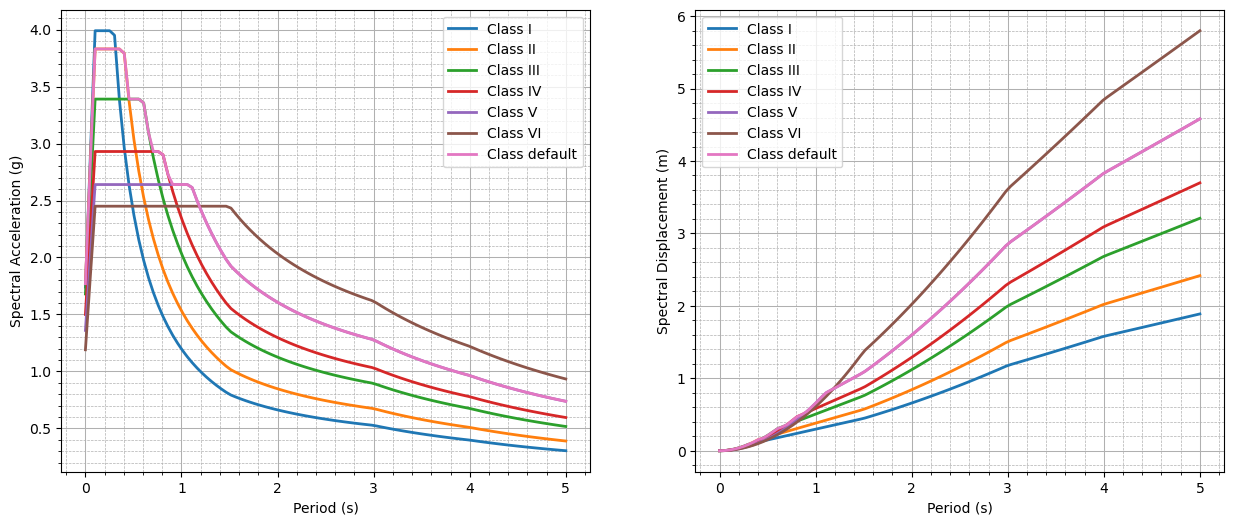

In [25]:
# Define site location. Options are address, lat/long, urban location
# Examples in NZ
site_location = "1 Grey Street, Wellington" # Jacobs office in Wellington
#site_location = "-41.2849784,174.7762051" # Jacobs office in Wellington
#site_location = "-37.10971,174.94316"  # Ngaakooroa Stream Bridge

# Examples outside NZ
# site_location = "Brisbane"
#site_location = '7 Melbourne Ave, Australia'
#site_location = "-41.2849784,124.7762051"

# Get site coordinates
site_info = get_site_coordinate(site_location)  

# Get elastic spectra
spectra = process_data(site_info, return_period = 2500)

# Plot elastic spectra
plot_spectra(spectra)

# Show on the map
create_hazard_map(hazard_data_folder, site_location, save_map = False)

## Limitations.    
     
     1.0  Currently displaying acceleration and displacement spectra. Include vertical spectra.
     2.0  Shows all site classes including default one.  Need to update Vs30 based site classification.
     3.0  Display and save spectra in html format to keep it interactive. 
     4.0  Output spectral data in a csv format

In [24]:
!pip freeze

aiobotocore @ file:///C:/b/abs_3cwz1w13nn/croot/aiobotocore_1701291550158/work
aiohttp @ file:///C:/b/abs_27h_1rpxgd/croot/aiohttp_1707342354614/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_f4tsjyl9va/croot/anaconda-anon-usage_1695310457827/work
anaconda-catalogs @ file:///C:/b/abs_8btyy0o8s8/croot/anaconda-catalogs_1685727315626/work
anaconda-client @ file:///C:/b/abs_80wttmgui4/croot/anaconda-client_1694625288614/work
anaconda-cloud-auth @ file:///C:/b/abs_410afndtyf/croot/anaconda-cloud-auth_1697462767853/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project @ file:///C:/ci_311/anaconda-project_1676458365912/work
anyio @ file:///C:/b/abs_847uobe7ea/croot/anyio_1706220224037/work
appdirs==1.4.4
aquarel==0.0.6
argon2-cf